# STOR 320: Introduction to Data Science
## EDA Group PLACE_GROUP_NUMBER_HERE (Ex: EDA Group 12)

## Part 1: Data cleaning, merging, and visualization (6 points)

In [210]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from geopy.distance import geodesic



In [211]:
flights = pd.read_csv('flights.csv')
hotel = pd.read_csv('hotel_bookings.csv')

In [212]:
## column names check (1 point)
print(flights.columns)
hotel.columns

Index(['id', 'year', 'month', 'day', 'dep_time', 'sched_dep_time', 'dep_delay',
       'arr_time', 'sched_arr_time', 'arr_delay', 'carrier', 'flight',
       'tailnum', 'origin', 'dest', 'air_time', 'distance', 'hour', 'minute',
       'time_hour', 'name'],
      dtype='object')


Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

In [243]:
## missing data check (1 point)
print(flights.isnull().sum())
hotel.isnull().sum()

id                   0
year                 0
month                0
day                  0
dep_time          8255
sched_dep_time       0
dep_delay         8255
arr_time          8713
sched_arr_time       0
arr_delay         9430
carrier              0
flight               0
tailnum           2512
origin               0
dest                 0
air_time          9430
distance             0
hour                 0
minute               0
time_hour            0
name                 0
dtype: int64


hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

           arr_delay      dep_delay       distance       air_time
count  327346.000000  328521.000000  336776.000000  327346.000000
mean        6.895377      12.639070    1039.912604     150.686460
std        44.633292      40.210061     733.233033      93.688305
min       -86.000000     -43.000000      17.000000      20.000000
25%       -17.000000      -5.000000     502.000000      82.000000
50%        -5.000000      -2.000000     872.000000     129.000000
75%        14.000000      11.000000    1389.000000     192.000000
max      1272.000000    1301.000000    4983.000000     695.000000
           lead_time  previous_cancellations  previous_bookings_not_canceled  \
count  119390.000000           119390.000000                   119390.000000   
mean      104.011416                0.087118                        0.137097   
std       106.863097                0.844336                        1.497437   
min         0.000000                0.000000                        0.000000   
25%   

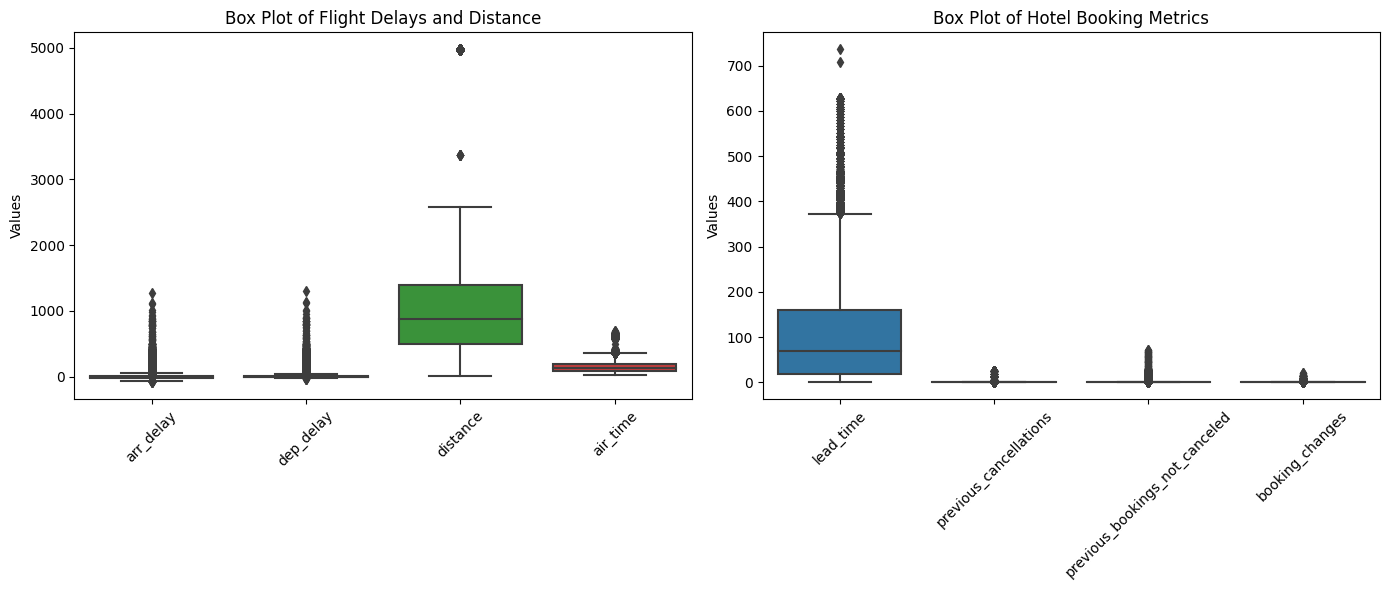

In [214]:
## Outlier check (1 point)
print(flights.describe()[['arr_delay','dep_delay','distance','air_time']])
print(hotel.describe()[['lead_time','previous_cancellations','previous_bookings_not_canceled','booking_changes']])

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data=flights[['arr_delay', 'dep_delay', 'distance', 'air_time']])
plt.title('Box Plot of Flight Delays and Distance')
plt.ylabel('Values')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.boxplot(data=hotel[['lead_time', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes']])
plt.title('Box Plot of Hotel Booking Metrics')
plt.ylabel('Values')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [244]:
## data merging (1 point)
month_mapping = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}
hotel['arrival_date_month_numeric'] = hotel['arrival_date_month'].map(month_mapping)

flights['month'] = flights['month'].astype(int)
flights['day'] = flights['day'].astype(int)
hotel['arrival_date_month_numeric'] = hotel['arrival_date_month_numeric'].astype(int)
hotel['arrival_date_day_of_month'] = hotel['arrival_date_day_of_month'].astype(int)
hotel['arrival_date_year'] = hotel['arrival_date_year'].astype(int)

hotel_filtered = hotel[
    (hotel['country'] == 'USA') & 
    (hotel['arrival_date_year'] == 2016) &
    (hotel['arrival_date_month_numeric'] >= 1) &
    (hotel['arrival_date_month_numeric'] <= 9) &
    (
        (hotel['arrival_date_month_numeric'] < 9) |
        (hotel['arrival_date_day_of_month'] <= 30)
    )
]

merged_data = pd.merge(
    flights, hotel_filtered, 
    left_on=['month', 'day'], 
    right_on=['arrival_date_month_numeric', 'arrival_date_day_of_month'], 
    how='inner'
)
merged_data[['hour','origin','dest','time_hour','name']]

,hour,origin,dest,time_hour,name
0,5,EWR,IAH,2013-01-01 05:00:00,United Air Lines Inc.
1,5,LGA,IAH,2013-01-01 05:00:00,United Air Lines Inc.
2,5,JFK,MIA,2013-01-01 05:00:00,American Airlines Inc.
3,5,JFK,BQN,2013-01-01 05:00:00,JetBlue Airways
4,6,LGA,ATL,2013-01-01 06:00:00,Delta Air Lines Inc.
...,...,...,...,...,...
694147,11,LGA,CLE,2013-09-30 11:00:00,Envoy Air
694148,11,LGA,CLE,2013-09-30 11:00:00,Envoy Air
694149,8,LGA,RDU,2013-09-30 08:00:00,Envoy Air
694150,8,LGA,RDU,2013-09-30 08:00:00,Envoy Air


In [245]:
## data transformation, normalization, and cleaning (1 point)

In [246]:
merged_data.columns

Index(['id', 'year', 'month', 'day', 'dep_time', 'sched_dep_time', 'dep_delay',
       'arr_time', 'sched_arr_time', 'arr_delay', 'carrier', 'flight',
       'tailnum', 'origin', 'dest', 'air_time', 'distance', 'hour', 'minute',
       'time_hour', 'name', 'hotel', 'is_canceled', 'lead_time',
       'arrival_date_year', 'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date',
       'arrival_date_month_numeric'],
      dtype='obje

In [248]:
cleaned_merged_data = merged_data[[#'id', 
    'year', 'month', 'day', 'dep_time', 'sched_dep_time', 'dep_delay',
       'arr_time', 'sched_arr_time', 'arr_delay', 'carrier', 
       #'flight','tailnum', 
       'origin', 'dest', 'air_time', 'distance',
        'hour', 'minute', 'time_hour', 
        'name', 
        
        'hotel', 'is_canceled', 'lead_time',
       'arrival_date_year', 'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 
       #'meal',
       'country', 
       'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 
       #'reserved_room_type',
       #'assigned_room_type', 
       'booking_changes', 
       'deposit_type', 
       #'agent',
       #'company', 
       'days_in_waiting_list', 'customer_type', 
       'adr',
       'required_car_parking_spaces', 'total_of_special_requests', 'reservation_status',
       'reservation_status_date',
       'arrival_date_month_numeric']].dropna()
cleaned_merged_data

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,...,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date_month_numeric
0,2013,1,1,517.0,515,2.0,830.0,819,11.0,UA,...,0,No Deposit,0,Transient,92.0,0,1,Check-Out,2016-01-03,1
1,2013,1,1,533.0,529,4.0,850.0,830,20.0,UA,...,0,No Deposit,0,Transient,92.0,0,1,Check-Out,2016-01-03,1
2,2013,1,1,542.0,540,2.0,923.0,850,33.0,AA,...,0,No Deposit,0,Transient,92.0,0,1,Check-Out,2016-01-03,1
3,2013,1,1,544.0,545,-1.0,1004.0,1022,-18.0,B6,...,0,No Deposit,0,Transient,92.0,0,1,Check-Out,2016-01-03,1
4,2013,1,1,554.0,600,-6.0,812.0,837,-25.0,DL,...,0,No Deposit,0,Transient,92.0,0,1,Check-Out,2016-01-03,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
694129,2013,9,30,2307.0,2255,12.0,2359.0,2358,1.0,B6,...,0,No Deposit,0,Transient,136.0,1,1,Check-Out,2016-10-01,9
694130,2013,9,30,2307.0,2255,12.0,2359.0,2358,1.0,B6,...,1,No Deposit,0,Transient,215.0,0,0,Check-Out,2016-10-03,9
694131,2013,9,30,2349.0,2359,-10.0,325.0,350,-25.0,B6,...,0,No Deposit,0,Transient,139.0,0,0,Canceled,2016-07-23,9
694132,2013,9,30,2349.0,2359,-10.0,325.0,350,-25.0,B6,...,0,No Deposit,0,Transient,136.0,1,1,Check-Out,2016-10-01,9


In [249]:
cleaned_merged_data['arrival_date'] = pd.to_datetime(
    cleaned_merged_data['arrival_date_year'].astype(str) + '-' +
    cleaned_merged_data['arrival_date_month_numeric'].astype(str) + '-' +
    cleaned_merged_data['arrival_date_day_of_month'].astype(str),
    errors='coerce'
)

cleaned_merged_data.drop(['arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month', 'arrival_date_month_numeric'], axis=1, inplace=True)

cleaned_merged_data[['arrival_date']].head()

#makes a date time column

,arrival_date
0,2016-01-01
1,2016-01-01
2,2016-01-01
3,2016-01-01
4,2016-01-01


In [250]:
cleaned_merged_data['arrival_date'] = pd.to_datetime(cleaned_merged_data['arrival_date'], errors='coerce')
cleaned_merged_data['reservation_status_date'] = pd.to_datetime(cleaned_merged_data['reservation_status_date'], errors='coerce')

#  Convers to data time

In [251]:
cleaned_merged_data['dep_time_full'] = pd.to_datetime(cleaned_merged_data['arrival_date'].astype(str) + ' ' + 
                                              cleaned_merged_data['hour'].astype(str) + ':' + 
                                              cleaned_merged_data['minute'].astype(str), errors='coerce')

# Reformats to date time

In [252]:
if 'dep_time' in cleaned_merged_data.columns and 'sched_dep_time' in cleaned_merged_data.columns:
    cleaned_merged_data['dep_time'] = pd.to_datetime(cleaned_merged_data['dep_time'], format='%H%M', errors='coerce')
    cleaned_merged_data['sched_dep_time'] = pd.to_datetime(cleaned_merged_data['sched_dep_time'], format='%H%M', errors='coerce')
    cleaned_merged_data['dep_delay_calc'] = (cleaned_merged_data['dep_time'] - cleaned_merged_data['sched_dep_time']).dt.total_seconds() / 60

In [253]:
if 'arr_time' in cleaned_merged_data.columns and 'sched_arr_time' in cleaned_merged_data.columns:
    cleaned_merged_data['arr_time'] = pd.to_datetime(cleaned_merged_data['arr_time'], format='%H%M', errors='coerce')
    cleaned_merged_data['sched_arr_time'] = pd.to_datetime(cleaned_merged_data['sched_arr_time'], format='%H%M', errors='coerce')
    cleaned_merged_data['arr_delay_calc'] = (cleaned_merged_data['arr_time'] - cleaned_merged_data['sched_arr_time']).dt.total_seconds() / 60

# Calculate delays based on existing columns if dep_time and sched_dep_time are present as times

In [254]:
continuous_features = ['dep_delay', 'arr_delay', 'lead_time', 'air_time', 'distance', 'days_in_waiting_list', 'adr']
scaler = StandardScaler()
cleaned_merged_data[continuous_features] = scaler.fit_transform(cleaned_merged_data[continuous_features])
#  Scales featues that may need tranformation

In [255]:
categorical_features = [#'company',
     'carrier', 
                       # 'meal', 'country', 
                       'market_segment', 'distribution_channel'
                       #'reserved_room_type', 'assigned_room_type'
                       ]
cleaned_merged_data = pd.get_dummies(cleaned_merged_data, columns=categorical_features, drop_first=True)
#  Takes data and makes it into diffrent catigoireis for later analysis

In [256]:
binary_features = ['is_canceled', 'is_repeated_guest']
cleaned_merged_data[binary_features] = cleaned_merged_data[binary_features].astype(int)
#  Turn binary data into binary (self expanitory)

In [257]:
count_features = ['previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'total_of_special_requests']
cleaned_merged_data[count_features] = scaler.fit_transform(cleaned_merged_data[count_features])
	
# Calculates the mean and standard deviation then applies the transformation to the data using the parameters

In [258]:
cleaned_merged_data['total_guests'] = cleaned_merged_data[['adults', 'children', 'babies']].sum(axis=1)
# Summing the total amounts of guests

In [259]:
cleaned_merged_data['reservation_status'] = cleaned_merged_data['reservation_status'].astype('category').cat.codes
# Convert regitration status to numerical codes

In [260]:
cleaned_merged_data.columns

Index(['year', 'month', 'day', 'dep_time', 'sched_dep_time', 'dep_delay',
       'arr_time', 'sched_arr_time', 'arr_delay', 'origin', 'dest', 'air_time',
       'distance', 'hour', 'minute', 'time_hour', 'name', 'hotel',
       'is_canceled', 'lead_time', 'arrival_date_week_number',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'country', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'arrival_date',
       'dep_time_full', 'dep_delay_calc', 'arr_delay_calc', 'carrier_AA',
       'carrier_AS', 'carrier_B6', 'carrier_DL', 'carrier_EV', 'carrier_F9',
       'carrier_FL', 'carrier_HA', 'carrier_MQ', 'carrier_OO', 'carrier_UA',
       'carrier_US', 'carrier_VX', 'carrier_WN', 'carrier_YV',


In [103]:
## Exploratory data visualization (1 point)

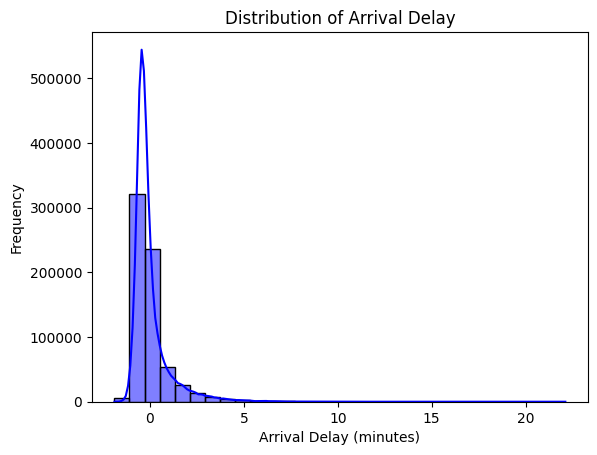

In [261]:
sns.histplot(cleaned_merged_data['arr_delay'], bins=30, kde=True, color='blue')
plt.title('Distribution of Arrival Delay')
plt.xlabel('Arrival Delay (minutes)')
plt.ylabel('Frequency')
plt.show()

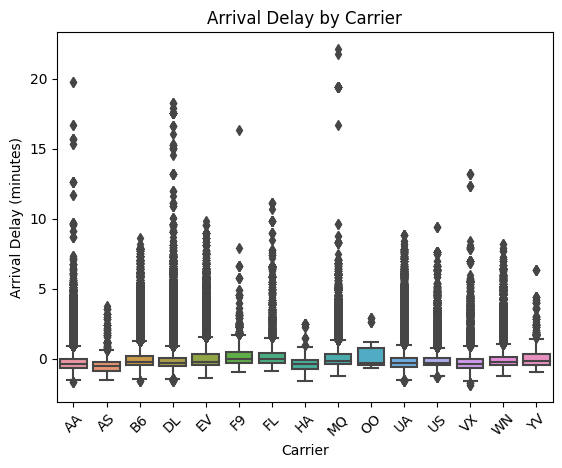

In [264]:
# select only the carrier dummy columns
carrier_cols = [col for col in cleaned_merged_data.columns if col.startswith("carrier_")]
df_carrier = cleaned_merged_data[carrier_cols + ['arr_delay']]
# melt the data
df_carrier_melted = df_carrier.melt(id_vars=['arr_delay'], var_name='carrier', value_name='indicator')
df_carrier_melted = df_carrier_melted[df_carrier_melted['indicator'] == 1]
df_carrier_melted['carrier'] = df_carrier_melted['carrier'].str.replace("carrier_", "")

sns.boxplot(x='carrier', y='arr_delay', data=df_carrier_melted)
plt.title('Arrival Delay by Carrier')
plt.xlabel('Carrier')
plt.ylabel('Arrival Delay (minutes)')
plt.xticks(rotation=45)
plt.show()

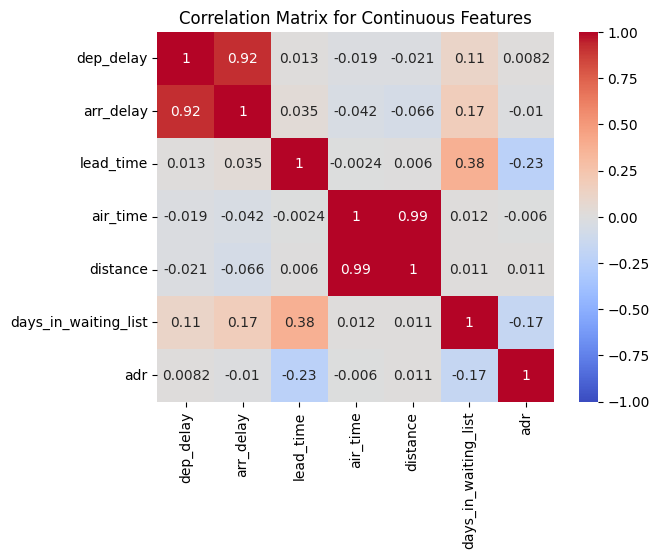

In [265]:
sns.heatmap(cleaned_merged_data[continuous_features].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix for Continuous Features')
plt.show()


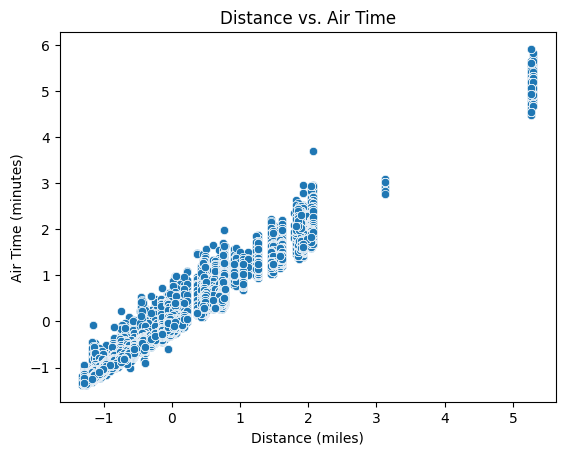

In [266]:
sns.scatterplot(x='distance', y='air_time', data=cleaned_merged_data)
plt.title('Distance vs. Air Time')
plt.xlabel('Distance (miles)')
plt.ylabel('Air Time (minutes)')
plt.show()

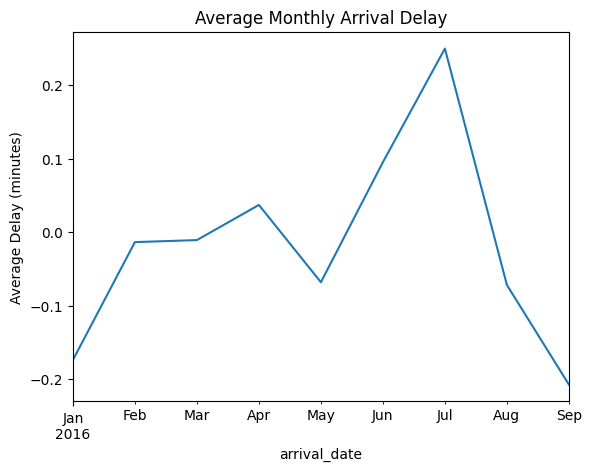

In [268]:
cleaned_merged_data.set_index('arrival_date', inplace=True)
cleaned_merged_data['arr_delay'].resample('M').mean().plot(title='Average Monthly Arrival Delay')
plt.ylabel('Average Delay (minutes)')
plt.show()

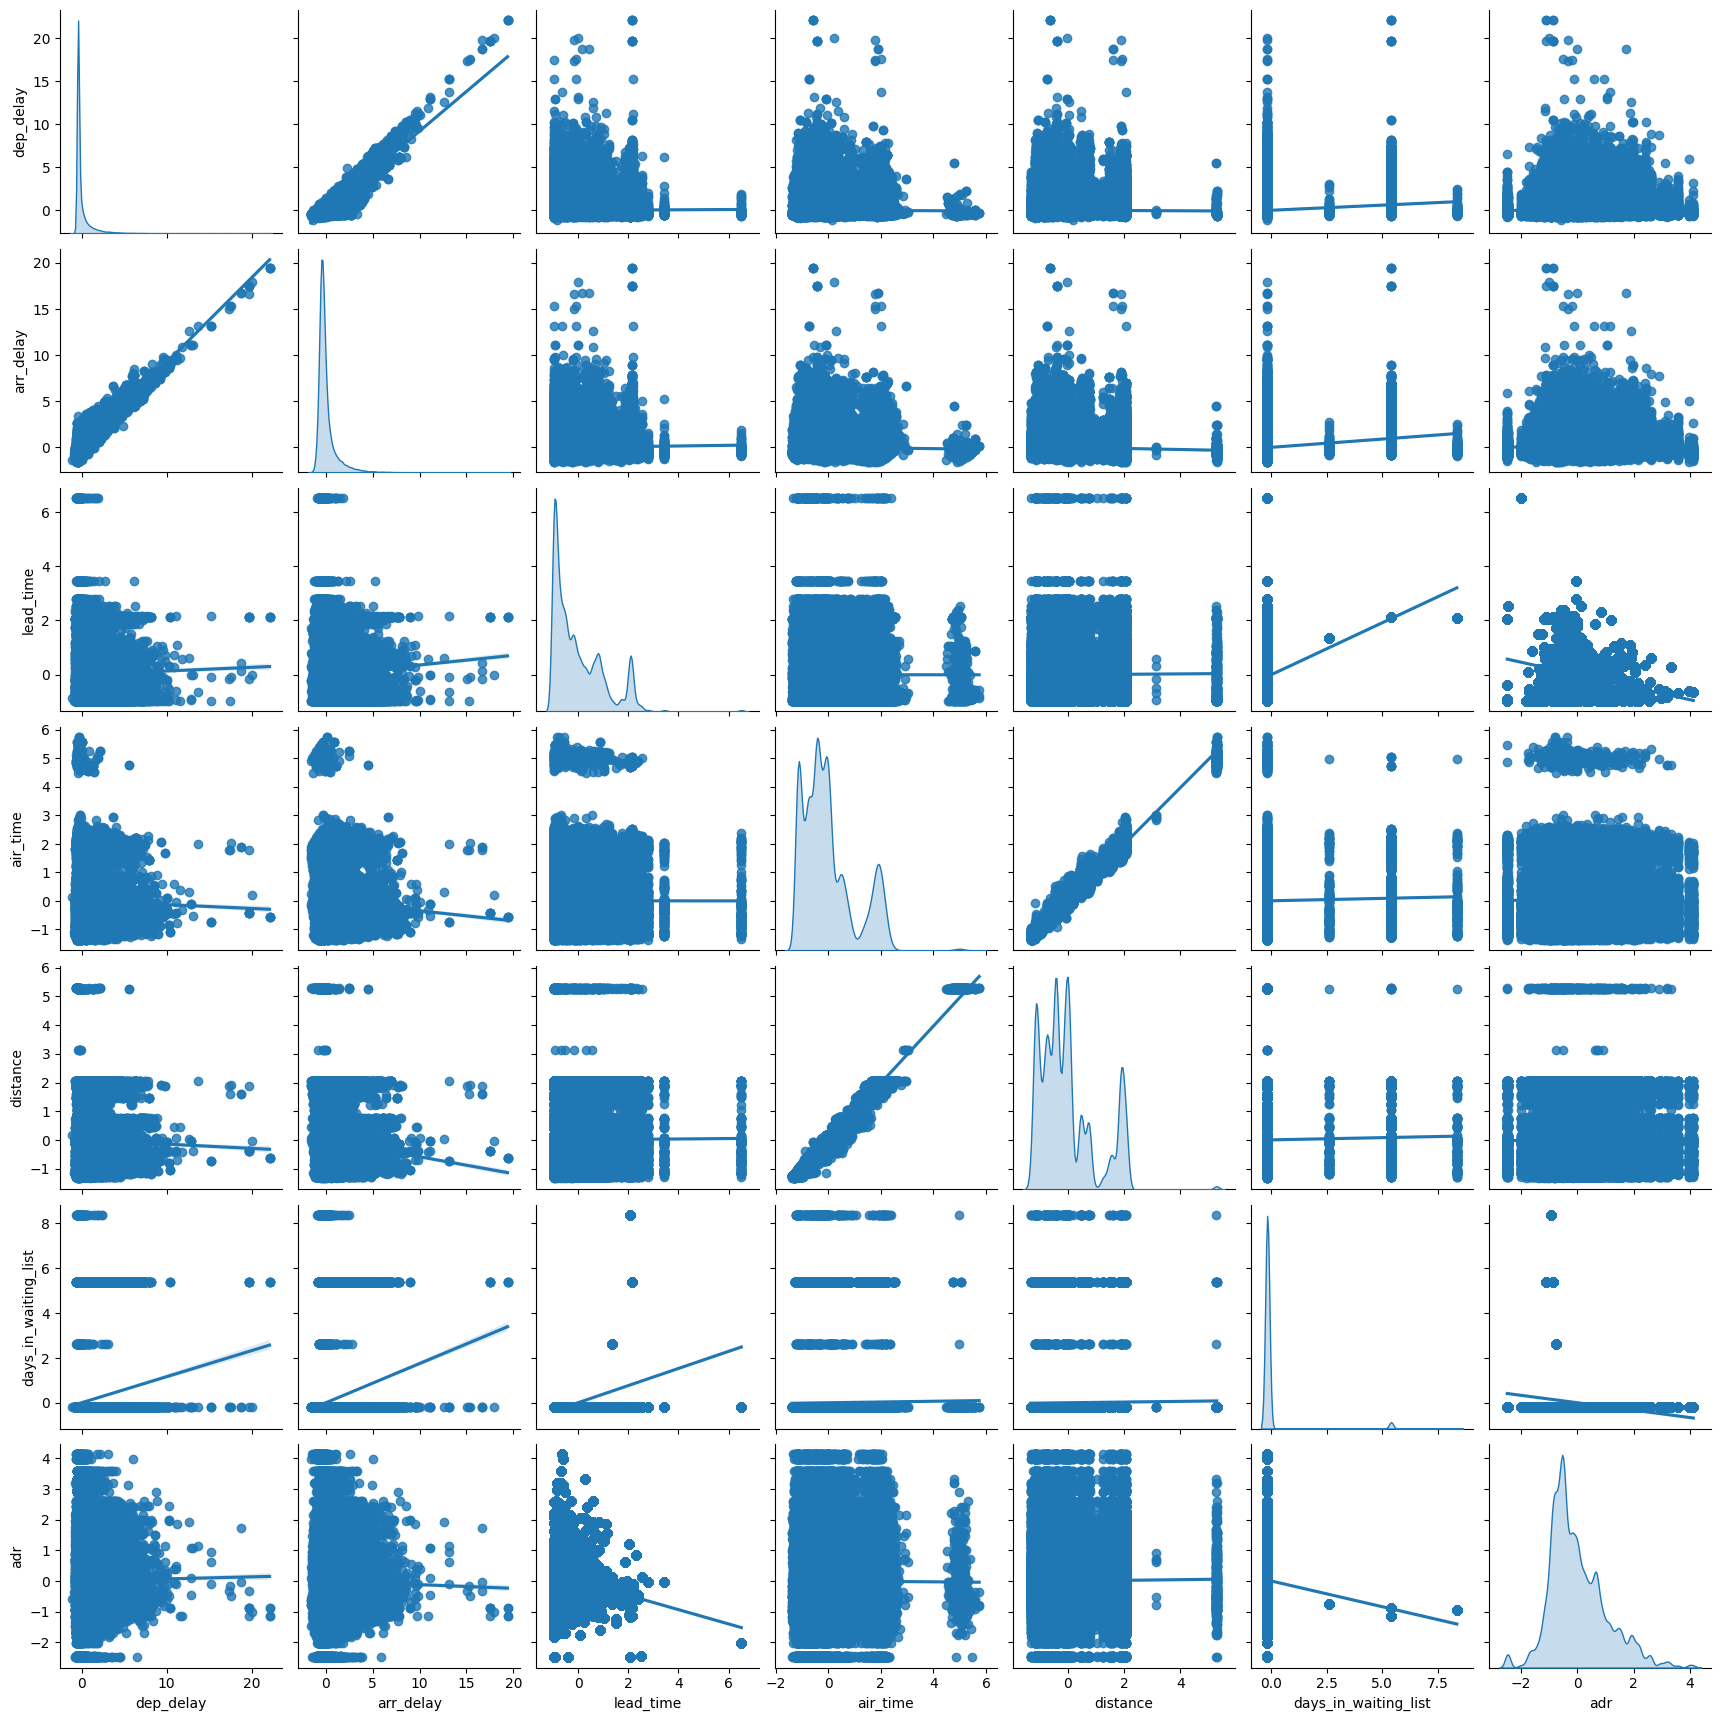

In [271]:
sample_data = cleaned_merged_data.sample(frac=0.2)
numeric_cols = sample_data[continuous_features].dropna()
numeric_cols_cleaned = numeric_cols.replace([np.inf, -np.inf], np.nan).dropna()
numeric_cols = numeric_cols.reset_index(drop=True)
sns.pairplot(numeric_cols_cleaned, kind='reg', diag_kind='kde')

In [139]:
print(numeric_cols.dtypes)
print(numeric_cols.isnull().sum())
np.isinf(numeric_cols).sum()

dep_delay               float64
arr_delay               float64
lead_time               float64
air_time                float64
distance                float64
days_in_waiting_list    float64
adr                     float64
dtype: object
dep_delay               0
arr_delay               0
lead_time               0
air_time                0
distance                0
days_in_waiting_list    0
adr                     0
dtype: int64


dep_delay               0
arr_delay               0
lead_time               0
air_time                0
distance                0
days_in_waiting_list    0
adr                     0
dtype: int64

## Part 2: Answer questions from the proposals (8 points)

Each plot should be followed by a paragraph of explanation and observation.

### Creator: FIRSTNAME LASTNAME

#### Question: How do weekday and weekend patterns differ for flights and hotel stays?

#### Answer:

### Interpreter 1: Conor Jones

#### Question: What is the association between lead time and cancellation for hotels?

#### Answer:

### Interpreter 2: Daniel Xu

#### Question: How do airlines compare on scheduling accuracy?

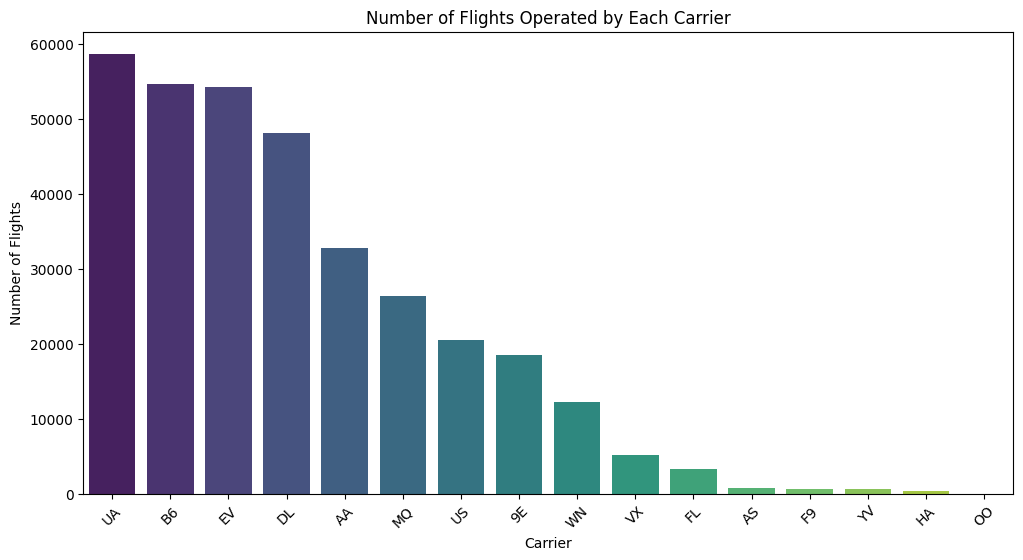

In [145]:
# Count the number of flights per carrier
flights_per_carrier = cleaned_merged_data['carrier'].value_counts().reset_index()
flights_per_carrier.columns = ['carrier', 'num_flights']
plt.figure(figsize=(12, 6))
sns.barplot(x='carrier', y='num_flights', data=flights_per_carrier, palette="viridis")
plt.title('Number of Flights Operated by Each Carrier')
plt.xlabel('Carrier')
plt.ylabel('Number of Flights')
plt.xticks(rotation=45)
plt.show()

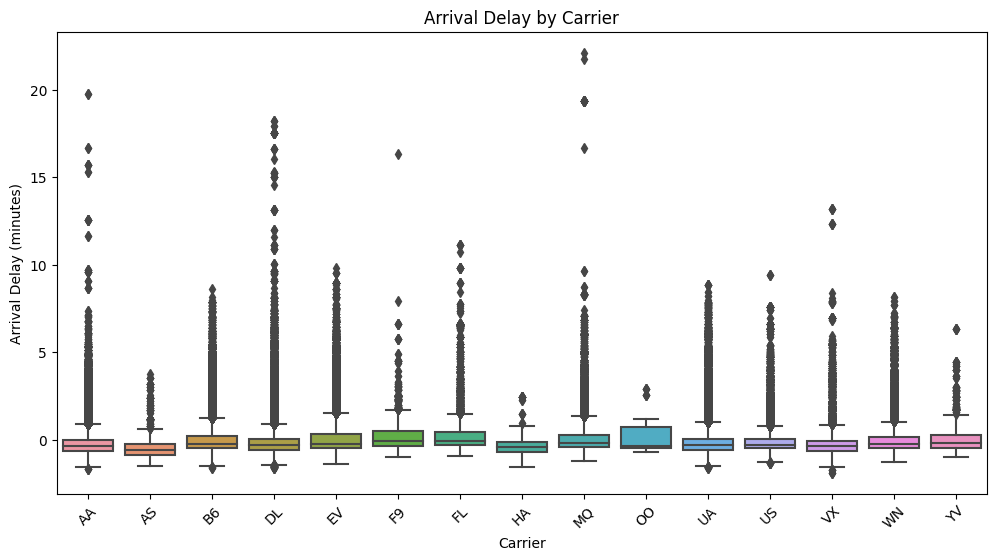

In [111]:
# select only the carrier dummy columns
carrier_cols = [col for col in merged_data.columns if col.startswith("carrier_")]
df_carrier = merged_data[carrier_cols + ['arr_delay']]
# melt the data
df_carrier_melted = df_carrier.melt(id_vars=['arr_delay'], var_name='carrier', value_name='indicator')
df_carrier_melted = df_carrier_melted[df_carrier_melted['indicator'] == 1]
df_carrier_melted['carrier'] = df_carrier_melted['carrier'].str.replace("carrier_", "")

plt.figure(figsize=(12, 6))
sns.boxplot(x='carrier', y='arr_delay', data=df_carrier_melted)
plt.title('Arrival Delay by Carrier')
plt.xlabel('Carrier')
plt.ylabel('Arrival Delay (minutes)')
plt.xticks(rotation=45)
plt.show()

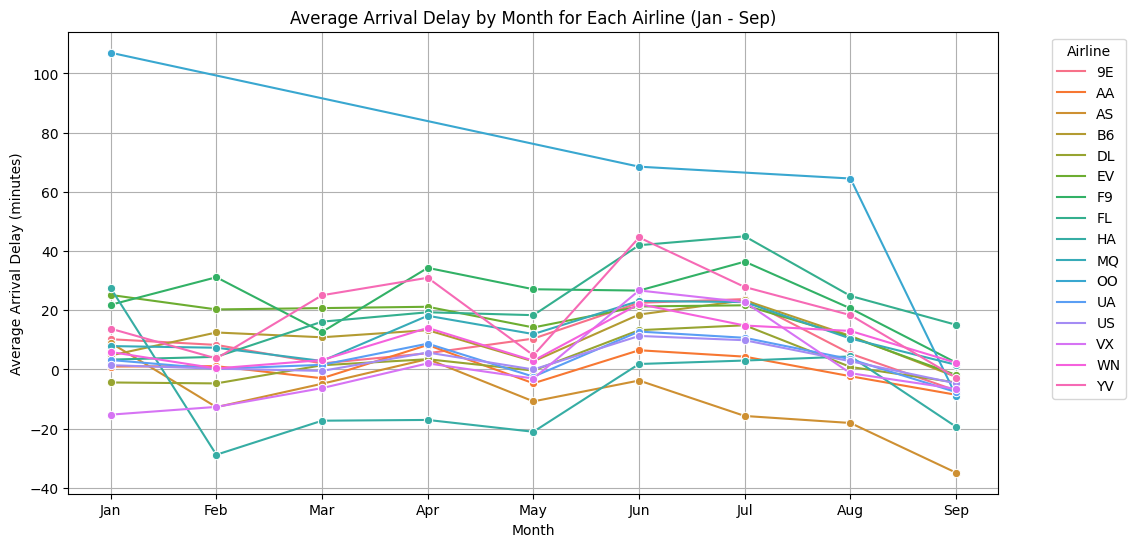

In [146]:
average_delay_per_month = (
    flights.groupby(['month', 'carrier'])['arr_delay']
    .mean()
    .reset_index()
)

# Filter to include only the months January to September
average_delay_per_month = average_delay_per_month[average_delay_per_month['month'].isin(range(1, 10))]

# Create a line plot for average arrival delay by month for each airline
plt.figure(figsize=(12, 6))
sns.lineplot(data=average_delay_per_month, x='month', y='arr_delay', hue='carrier', marker='o')

# Add titles and labels
plt.title('Average Arrival Delay by Month for Each Airline (Jan - Sep)')
plt.xlabel('Month')
plt.ylabel('Average Arrival Delay (minutes)')

# Set x-ticks for the months available in the dataset
plt.xticks(ticks=range(1, 10), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'])
plt.legend(title='Airline', bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside the plot
plt.grid(True)
plt.show()

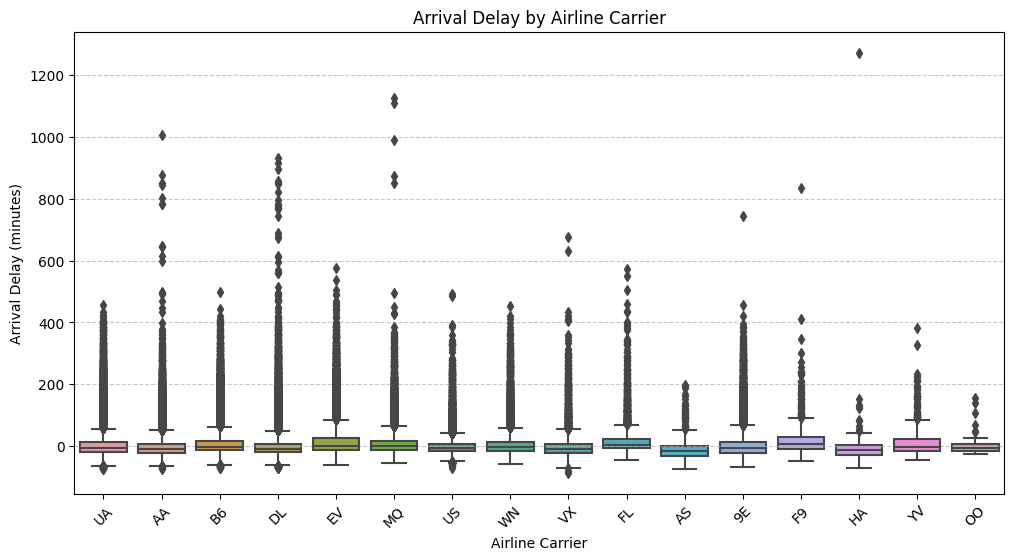

In [130]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='carrier', y='arr_delay', data=flights)
plt.title('Arrival Delay by Airline Carrier')
plt.xlabel('Airline Carrier')
plt.ylabel('Arrival Delay (minutes)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Optional: add grid for better readability
plt.show()

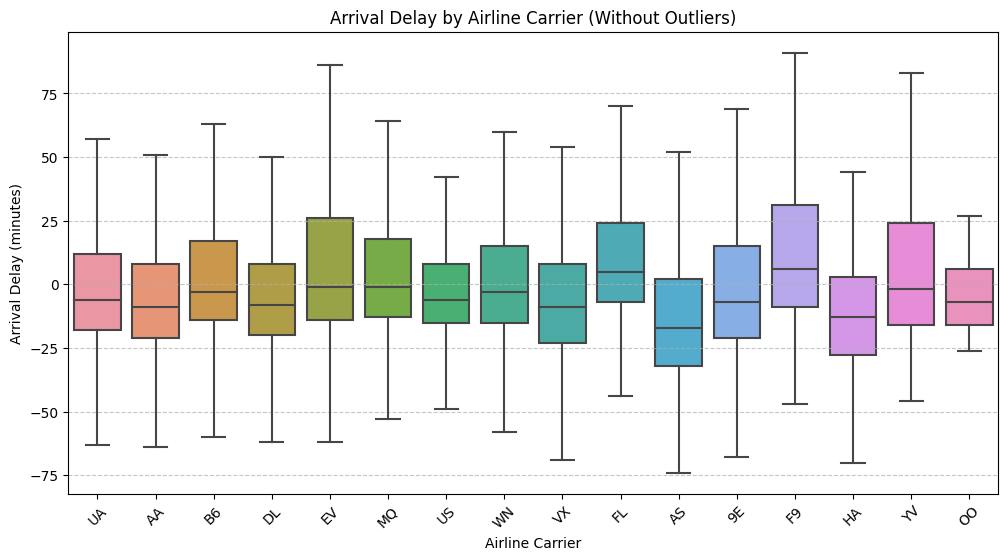

In [131]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='carrier', y='arr_delay', data=flights, showfliers=False)
plt.title('Arrival Delay by Airline Carrier (Without Outliers)')
plt.xlabel('Airline Carrier')
plt.ylabel('Arrival Delay (minutes)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Optional: add grid for better readability
plt.show()

In [147]:
flights['carrier'].unique()

array(['UA', 'AA', 'B6', 'DL', 'EV', 'MQ', 'US', 'WN', 'VX', 'FL', 'AS',
       '9E', 'F9', 'HA', 'YV', 'OO'], dtype=object)

#### Answer:

### Deliverer: Sichen Li

#### Question: Which is the best month to travel to avoid the peak season?

#### Answer:

## Part 3: Follow-up Questions (4 points)

### New Questions Based Off Initial Investigation

- Q1: WRITE_QUESTION_HERE
- Q2: WRITE_QUESTION_HERE

## Summary (2 points)

GIVE A 2 PARAGRAPH SUMMARY. 

PARAGRAPH 1 SHOULD DESCRIBE WHAT YOU LEARNED ABOUT YOUR DATA FROM INVESTIGATING THE INITIAL QUESTIONS. DID YOU FIND ANYTHING UNUSUAL IN YOUR DATA? DID ANYTHING SURPRISE YOU? WHICH OF THE INITIAL QUESTIONS WERE HELPFUL IN LEADING YOU TO MORE QUESTIONS?

PARAGRAPH 2 SHOULD SUMMARIZE WHAT YOU LEARNED FROM INVESTIGATING THE FOLLOW-UP QUESTIONS. WHY ARE THESE FOLLOW-UP QUESTIONS INTERESTING FOR INVESTIGATION? DESCRIBE THE TABLES/FIGURES YOU USED TO EXPLORE ANSWERS TO THESE FOLLOW-UP QUESTIONS? WHAT DID YOU LEARN FROM THE TABLES/FIGURES REGARDING THE FOLLOW-UP QUESTIONS YOU PROPOSED?